In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Power Up or Power Out: Predicting Power System Stability of Microgrids with Decentralized Control

Prepared by: Jephraim Manansala

<img src='src/grid.png' width=500>

## 1. Executive Summary

Predicting the power system stability of an electrical network is of upmost importance since electricity has been the backbone of modern society and a blackout can cause negative implications among businesses and institutions. With this in mind, machine learning classification models were developed to address this problem and the results have been promising. 

The classification metric used was the recall score because of the importance of detecting all of the actual relevant items in this specific problem. Out of the nine machine learning models implemented, it was the Non-linear Support Vector Machine model that yielded the highest recall of 97%. However, it should be highlighted that even though the models were focused on the recall score, the Non-linear Support Vector Machine achieved a high score for both the precision and recall score. This only shows the value of applying domain knowledge on how machine learning models are implemented. Since it was known that the relationship of the system operating parameters (`p`, `tau` and `g`) are polynomial in nature, a polynomial kernel was used on the Non-linear Support Vector Machine. The model yielded a 97% precision and recall score. The high score on both the classification metric of precision and recall score shows the appropriateness of this machine learning model to the problem at hand. 

## 2. Introduction

Electricity has been the backbone of the modern society and has been serving millions of people for several decades. However, behind the ease and comfort that electricity provides to our society is the complexity and intricacies that goes behind the eyes of the people. One of the several factors that needs to be considered is the Power System Stability of the electrical network. Simply put, maintaining the stability of the electrical network is imperative to ensure the reliable and continuous operation of the entire grid - otherwise, localized or grid-wide blackouts can occur if not mitigated immediately. Since electricity has been the backbone of modern society, a blackout can cause negative implications among businesses and institutions. Thus, there is a great need to predict system instability. 

To name a few, some of the considerations in the Power System Stability are:
1. Electricity is consumed by the load almost instantaneously as it is produced by the generators (even if it spans kilometers). Because of this, stability control methods need to detect and react to stability concerns in an instant to mitigate the problem.
2. To maintain power system stability, there should be a balance between the supply (power generated) and demand (power consumed) throughout the entire grid. Disturbances and severe unusual operations can cause the supply and demand to fall out of balance and can cause the entire system to be unstable and shut down.

## 3.  Problem Statement and Rationale

Having the complexities and intricacies of the electrical grid in mind, the main question is:

    1. How can we predict the power system stability of a network with decentralized control?
    
    2. At what value of operating parameters will an electrical grid with a stable operation fall to an unstable operation?

## 4. Data Description and Methodology

#### Data Description

The data was gathered from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Electrical+Grid+Stability+Simulated+Data+) by Vadim Arzamasov. In a high level view, this dataset is contains the local stability analysis of the 4-node star system implementing Decentral Smart Grid Control concept.

The features in the system are the operating parameters and settings of the 4-node star system. For simplicity, please refer to the single line diagram below:

<img src="src/sld.png" width = "500"/> 

It has 11 predictive features, 1 non-predictive features and 2 target (one is continuous and one is categorical). These are the following:

1. **p1** (non-predictive) - nominal power produced by the electricity producer, p1 = p2 + p3 + p4
2. **p2, p3, p4** - nominal power consumed by the participants 
3. **tau1**: reaction time of electricity producer (range is 0.5 to 10s)
4. **tau2, tau3, tau4**: reaction time of participant (range is 0.5 to 10s)
5. **g1** - coefficient of price elasticity of the electricity producer. This measures how much a producer is willing to adapt their production (range is from 0.05 to 1s^-1)
6. **g2, g3, g4** - coefficient of price elasticity of the participants. This measures how much a consumer is willing to adapt their consumption (range is from 0.05 to 1s^-1)
7. **stabf**: the stability label of the system (categorical: stable/unstable)


#### Methodology

To predict the power system stability of a 4-node network, the following methodology will be conducted.

1. **Data Gathering** - This was done by downloading the data and importing the data into the JuPyter Notebook.
2. **Exploratory Data Analysis** - This was done by plotting the data features into scatter plot, boxplots and kdeplots to determine its relationship from each other. Drawing insights prior modeling will be useful for the domain knowledge to be implemented.
3. **Feature Engineering and Data Preparation** - From the insights gathered in the EDA, feature engineering will be done to prepare the data and add useful features in the study. The data will also be scaled using a MinMax Scaler to ensure similarity in metric in all features. 
4. **Modeling of a Machine Learning Classifier** - Different machine learning models will be implemented to determine which model will yield the best prediction accuracy.
5. **Draw Conclusions** - From the results of the machine learning models, insights and conclusions will be drawn to gather business value from the problem at hand. 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
from scipy.spatial.distance import euclidean, cityblock, cosine
from sklearn.model_selection import train_test_split

### The Dataset

In [4]:
grid = pd.read_csv('src/Data_for_UCI_named.csv')
grid.head(5)

tau1      tau2      tau3      tau4        p1        p2        p3  \
0  2.959060  3.079885  8.381025  9.780754  3.763085 -0.782604 -1.257395   
1  9.304097  4.902524  3.047541  1.369357  5.067812 -1.940058 -1.872742   
2  8.971707  8.848428  3.046479  1.214518  3.405158 -1.207456 -1.277210   
3  0.716415  7.669600  4.486641  2.340563  3.963791 -1.027473 -1.938944   
4  3.134112  7.608772  4.943759  9.857573  3.525811 -1.125531 -1.845975   

         p4        g1        g2        g3        g4      stab     stabf  
0 -1.723086  0.650456  0.859578  0.887445  0.958034  0.055347  unstable  
1 -1.255012  0.413441  0.862414  0.562139  0.781760 -0.005957    stable  
2 -0.920492  0.163041  0.766689  0.839444  0.109853  0.003471  unstable  
3 -0.997374  0.446209  0.976744  0.929381  0.362718  0.028871  unstable  
4 -0.554305  0.797110  0.455450  0.656947  0.820923  0.049860  unstable

### Define functions to be used

In [5]:
from src.Functions import classifier, knn_classifier, nsvm_classifier, tree_classifier
from src.Functions import weight_analysis, top_predictor, plot_feature_importances
from src.Functions import get_confusion, nearest_k, precision, recall, pr_curve

## 5. Exploratory Data Analysis

### 5.1. The unstable grid conditions cannot identified in the pair plots

The unstable grid conditions does not seem to have an underlying pattern when plotted pairwise in a scatter plot. No clear clustering can be found on the plots.

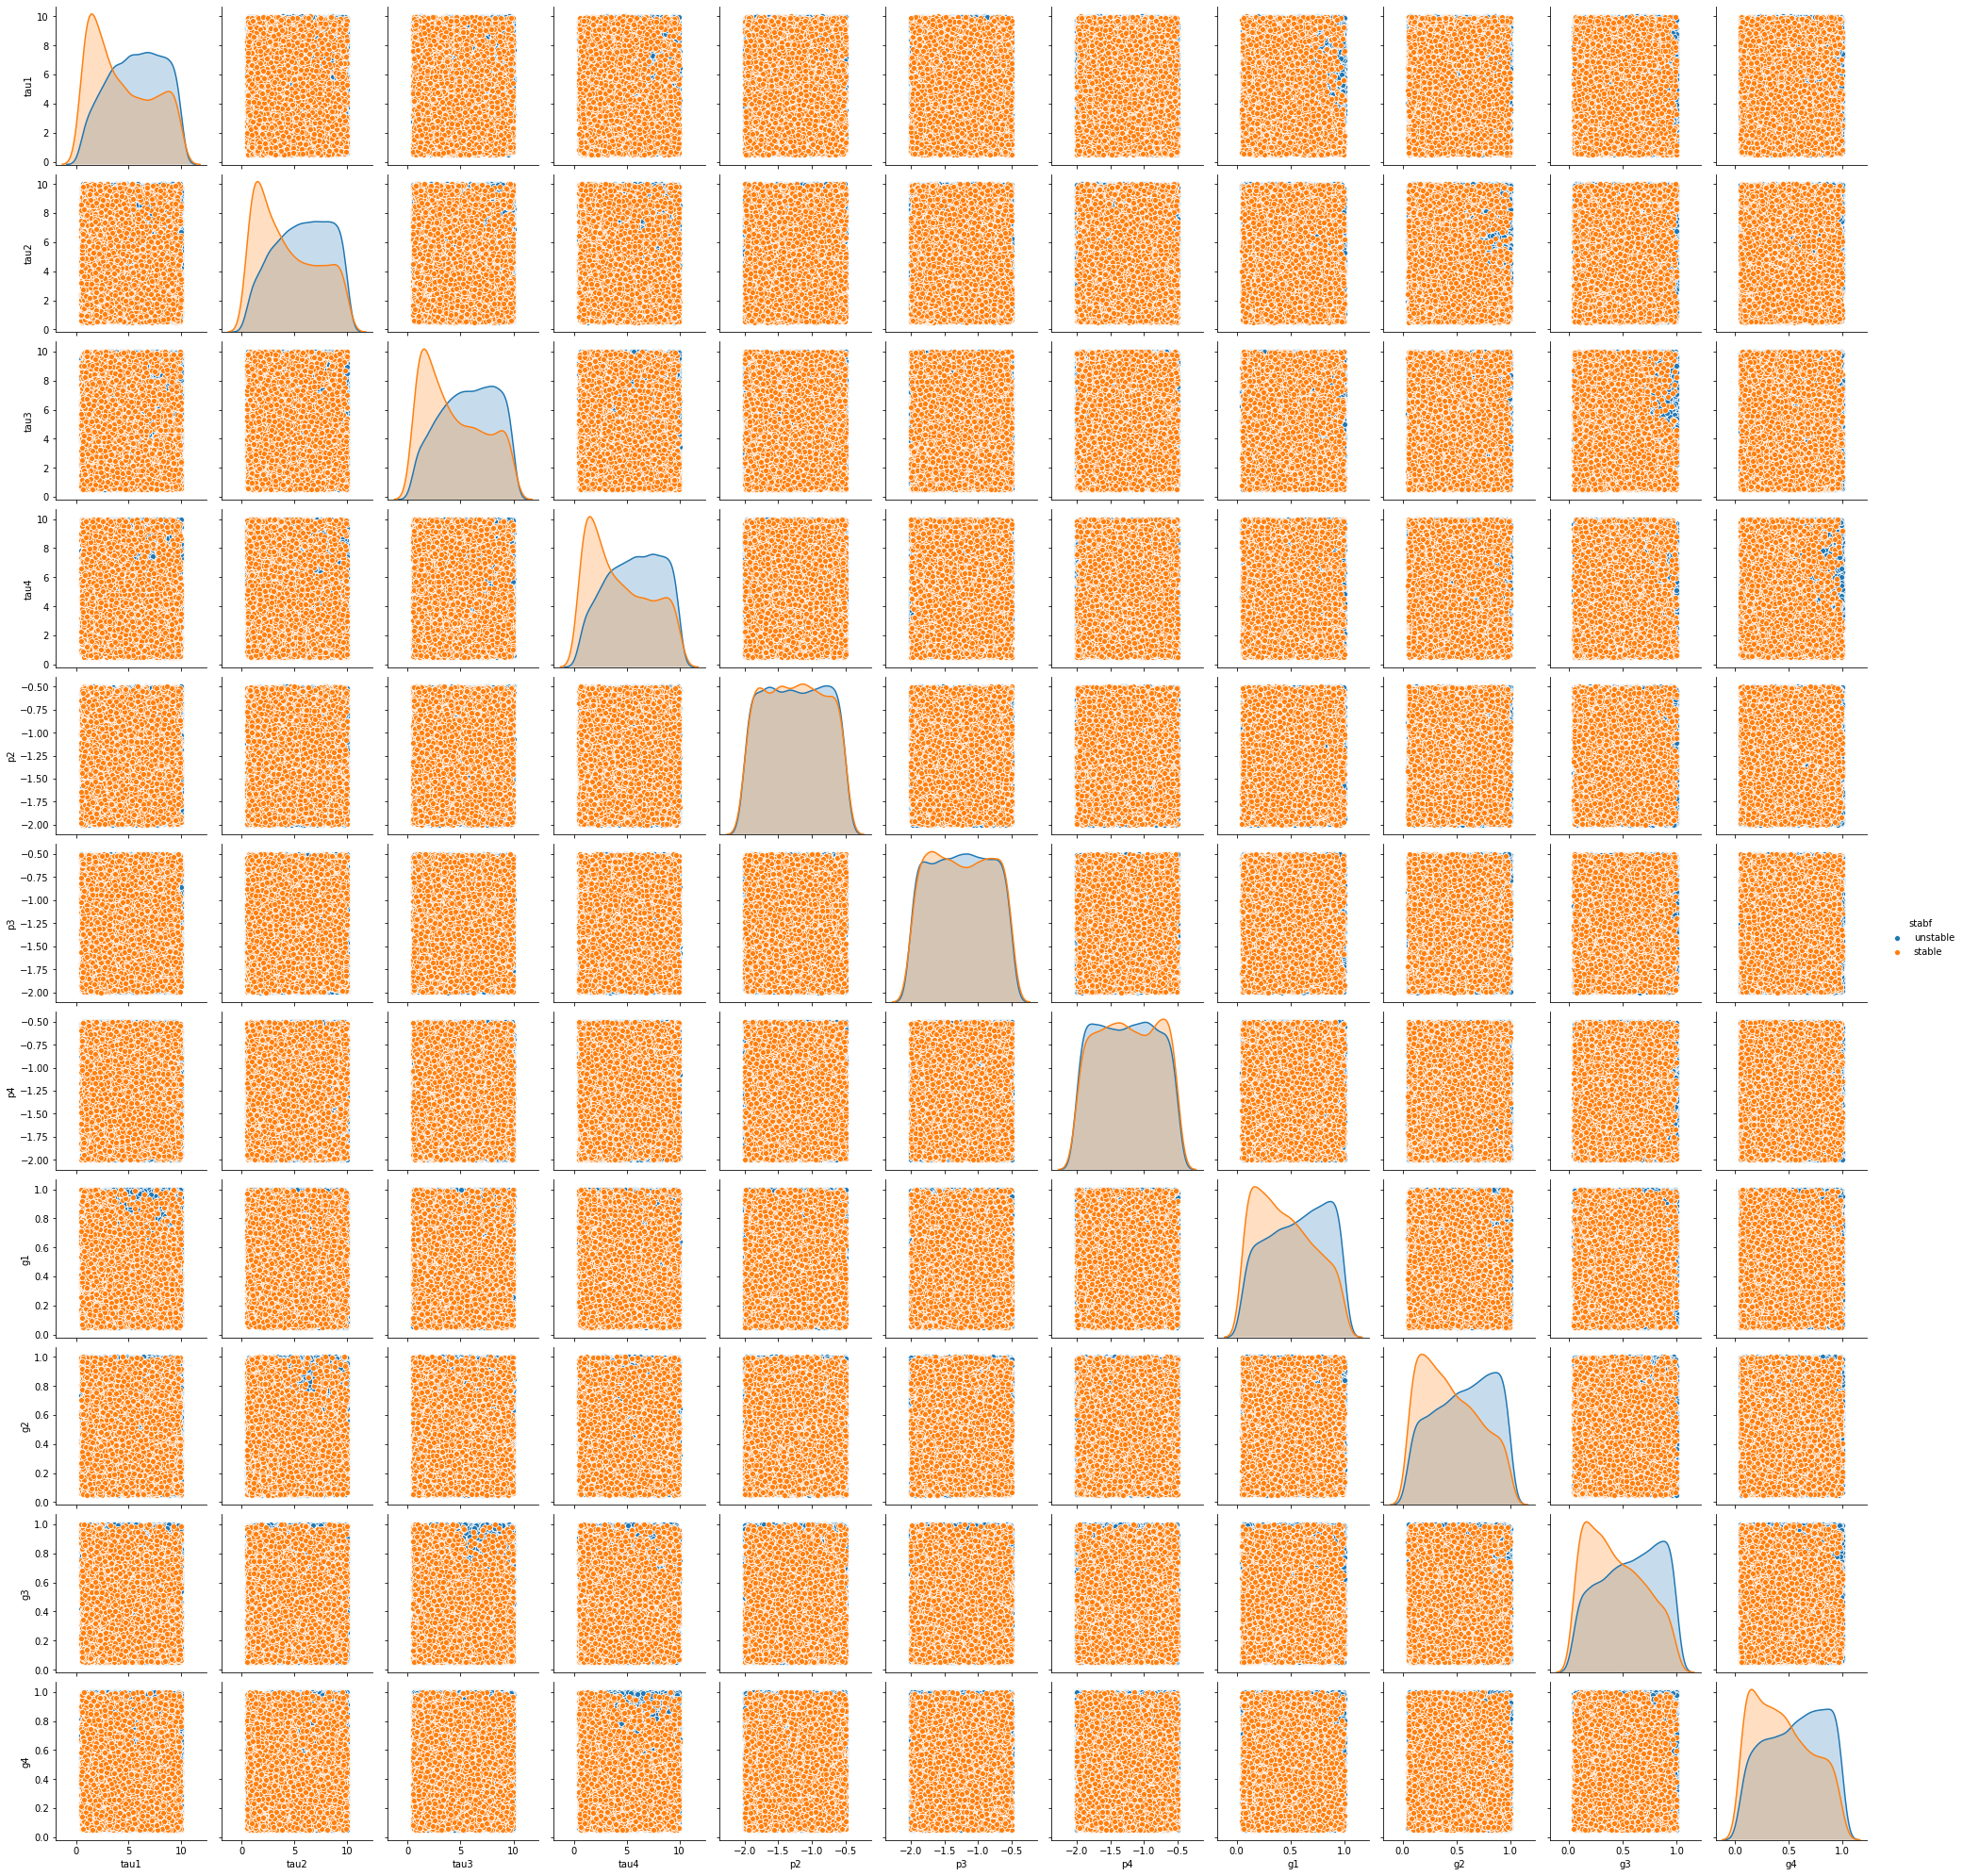

In [6]:
sns.pairplot(grid.drop(['p1', 'stab'], axis=1), hue='stabf');

### 5.2. No clear point of division between stable and unstable parameters

The kdeplot shows that there are clear overlaps on the parameters of the two network conditions. This might cause problems in the classifier since it will be harder for the model to find the difference between the two network conditions.

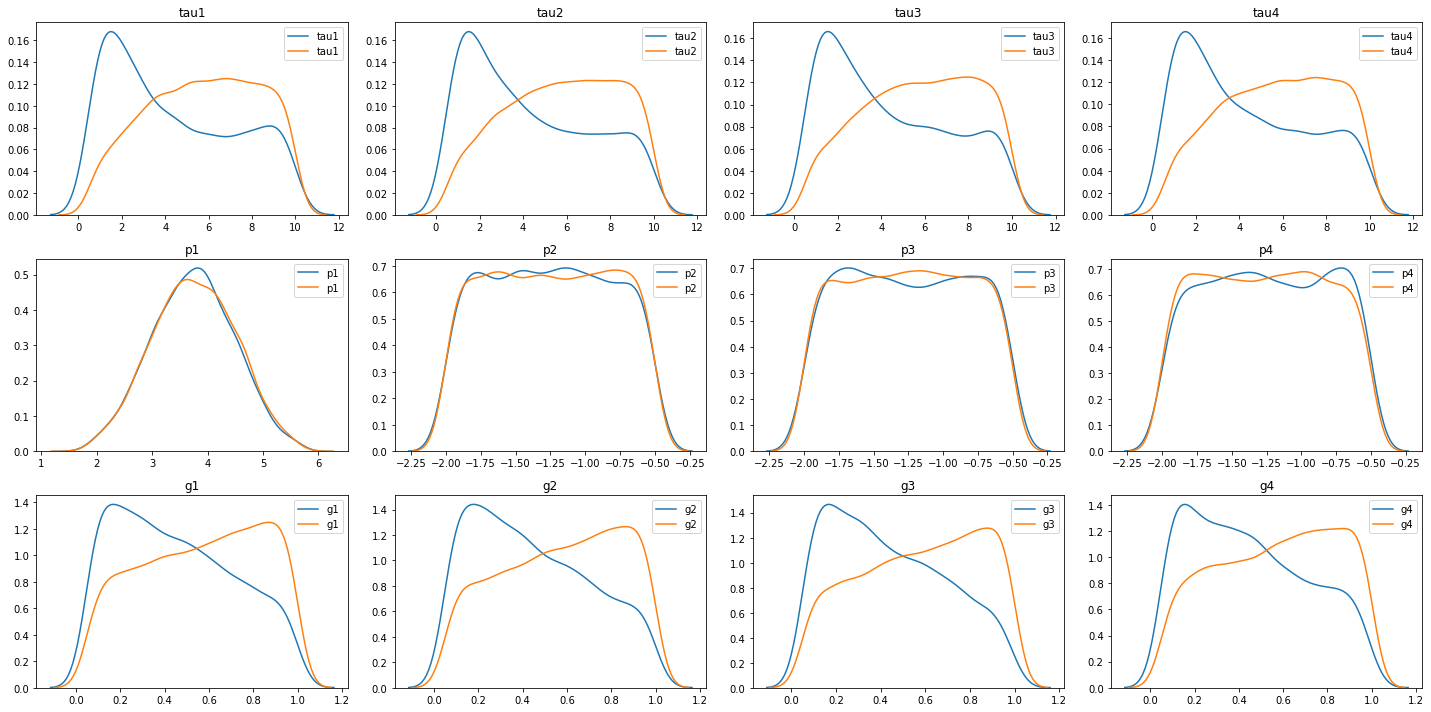

In [7]:
columns = grid.columns[:12]
fig, ax = plt.subplots(3, 4, figsize=(20,10))

for feature, ax_plt in zip(columns, ax.flatten()):
    sns.kdeplot(data=grid[grid['stabf']=='stable'][feature], ax=ax_plt)
    sns.kdeplot(data=grid[grid['stabf']=='unstable'][feature], ax=ax_plt)
    ax_plt.set_title(feature)
plt.tight_layout()

### 5.3. Overlaps in the IQR

The overlaps in the network operating parameters can clearly be seen in the boxplots wherein the inter-quartile ranges of each of the parameters are overlapping against each other. In fact, the boxplot of the `P` parameters are coinciding from each other while the unstable boxplot of the `tau` and `gamma` are slighly higher than that of the stable ones.

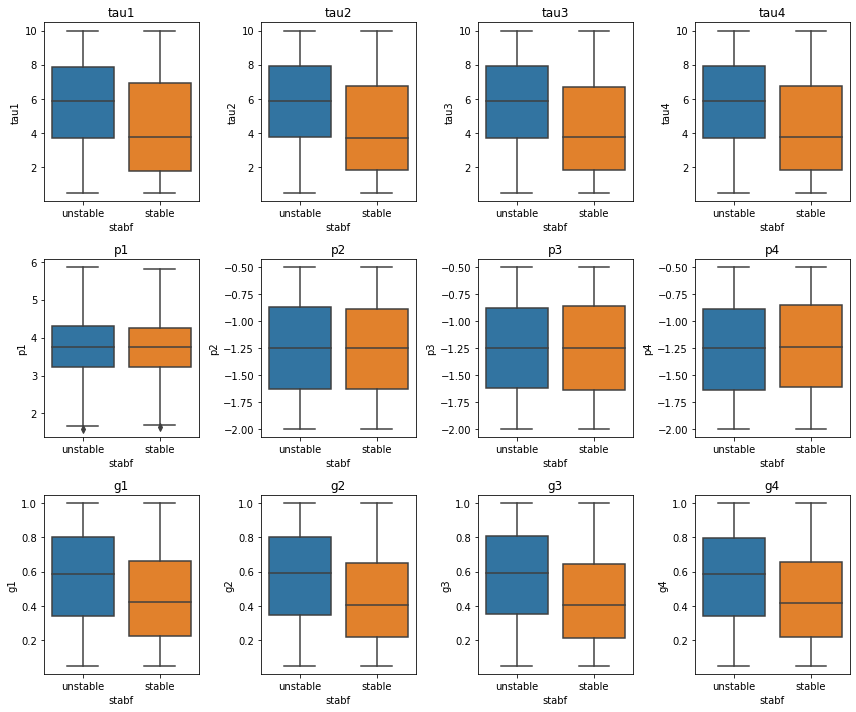

In [8]:
columns = grid.columns[:12]
fig, ax = plt.subplots(3, 4, figsize=(12,10))
for feature, ax_plt in zip(columns, ax.flatten()):
    sns.boxplot(x='stabf', y=feature, data=grid, ax=ax_plt)
    ax_plt.set_title(feature)
plt.tight_layout()

### 5.4. Baselines from Proportion Chance Criteria (PCC)

As a baseline, the PCC of the dataset was computed. The PCC of the dataset is around 53%. This is because the dataset have already (approximately) balanced the number of stable and unstable occurances by 60-40 ratio. This information will be useful in the machine learning modeling to ensure that the model will be better than chance. 

In [9]:
unstable = grid['stabf'].value_counts()['unstable']
stable = grid['stabf'].value_counts()['stable']
total = unstable + stable
PCC = (unstable/total)**2 + (stable/total)**2
print("PCC = ", PCC)
print("1.25 PCC =", 1.25*PCC)

PCC =  0.538088
1.25 PCC = 0.67261


## 6. Feature Engineering

From the exploratory data analysis, we can see that there are operating parameters and configuration of `tau` and `g` are very much close to each other which can cause a lower accuracy for the models. To mitigate this, feature engineering was done to ensure that there will be a column that can effectively split the stable from the unstable system operation. 

#### Create new columns `tau_system` and `g_system`

In [10]:
grid['tau_system'] = grid['tau1'] * grid['tau2'] * grid['tau3'] * grid['tau4']
grid['g_system'] = grid['g1'] * grid['g2'] * grid['g3'] * grid['g4']
X = grid.drop(['stab', 'stabf'], axis=1)
y = grid['stabf']

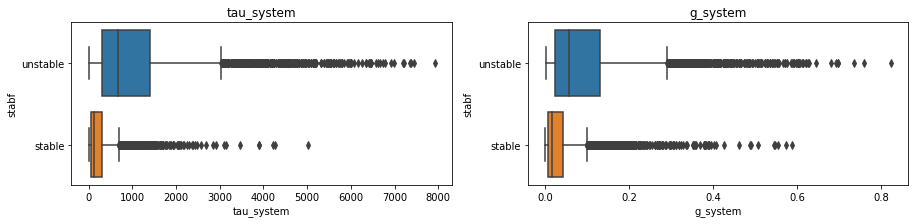

In [11]:
fig, ax = plt.subplots(1,2, figsize=(15,3))
sns.boxplot(x='tau_system', y='stabf', data=grid, ax=ax[0]);
sns.boxplot(x='g_system', y='stabf', data=grid, ax=ax[1]);
ax[0].set_title("tau_system");
ax[1].set_title("g_system");

By multiplying the `tau` and `g` values with each other, we can compute for the `tau_system` and `g_system` that will represent the overall `tau` and `g` value of the entire system. Because of this, it can be seen that the interquartile range (IQR) of the stable and unstable conditions are less overlapped from each other. This will be helpful in the development of the machine learning models since it will be easier to determine the differences between the two classifications. 

#### Scale the dataset

In [12]:
from sklearn.preprocessing import MinMaxScaler
mmscaler = MinMaxScaler()
X_scaled = mmscaler.fit_transform(X)

#### Split the dataset into testing and training dataset

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, 
                                                        test_size=0.25, 
                                                        stratify = y, 
                                                        random_state=1337)

## 7. Classifiers

With the observations in mind, the following machine learning classifier models are employed to detect and predict an unstable power system operation based on the network operating parameters. These methods are:

### 7.1. KNN Classifier

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [19:54<00:00, 119.45s/it]


Highest Test Recall = 0.968527
Highest Test Precision = 0.846191
Highest Training Accuracy = 0.888067
Highest Test Accuracy = 0.867560
Best KNN Neighbor = 23.000000


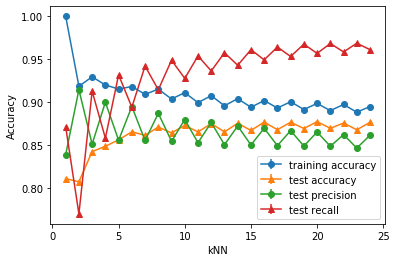

In [14]:
from sklearn.neighbors import KNeighborsClassifier
knn_classifier(X_scaled, y, iteration=10);

**INSIGHTS:**  Even though the best kNN parameter for recall is kNN=23, we choose kNN=11 to ensure that the test accuracy and precision will not be compromised greatly.

In [15]:
best_classifier = KNeighborsClassifier(n_neighbors=11).fit(X_train, y_train)

In [16]:
y_predict = best_classifier.predict(X_train)
index = np.where((y_predict == 'unstable'))[0]
confusion_matrix = get_confusion("unstable", index, y_train)
print("Train Precision is {:.6f}".format(precision(confusion_matrix)))
print("Train Recall is {:.6f}".format(recall(confusion_matrix)))
print("=========================")
y_predict = best_classifier.predict(X_test)
index = np.where((y_predict == 'unstable'))[0]
confusion_matrix = get_confusion("unstable", index, y_test)
print("Test Precision is {:.6f}".format(precision(confusion_matrix)))
print("Test Recall is {:.6f}".format(recall(confusion_matrix)))

Train Precision is 0.884968
Train Recall is 0.969488
Test Precision is 0.865175
Test Recall is 0.945455


###  7.2. Logistic Regression with L2 regularization

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.54s/it]


Highest Test Recall = 1.000000
Highest Test Precision = 0.638000
Highest Training Accuracy = 0.638000
Highest Test Accuracy = 0.638000
Best C Parameter = 0.001000


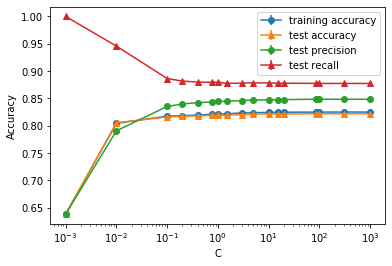

In [17]:
from sklearn.linear_model import LogisticRegression
classifier(LogisticRegression, X_scaled, y, iteration=10, max_iter=1000)

**INSIGHTS:** From the figure above, even though the best recall is when C=0.001, we choose C=0.1 to ensure that the test accuracy and precision will not be compromised greatly. Additionally, this is the value where the test scores become constant as the C increases. 

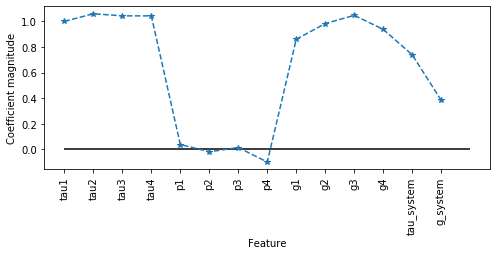

In [18]:
best_classifier = LogisticRegression(C=.01).fit(X_train, y_train)
weight_analysis(best_classifier, X)

**INSIGHTS:** From the figure, it can be seen that the top predictors are the `tau` and `g` parameters. Meanwhile, the `p` parameters have low weights which shows that it is a poor predictor for the system stability.

In [19]:
y_predict = best_classifier.predict(X_train)
index = np.where((y_predict == 'unstable'))[0]
confusion_matrix = get_confusion("unstable", index, y_train)
print("Train Precision is {:.6f}".format(precision(confusion_matrix)))
print("Train Recall is {:.6f}".format(recall(confusion_matrix)))
print("=========================")
y_predict = best_classifier.predict(X_test)
index = np.where((y_predict == 'unstable'))[0]
confusion_matrix = get_confusion("unstable", index, y_test)
print("Test Precision is {:.6f}".format(precision(confusion_matrix)))
print("Test Recall is {:.6f}".format(recall(confusion_matrix)))

Train Precision is 0.790588
Train Recall is 0.944410
Test Precision is 0.797009
Test Recall is 0.935423


### 7.3. Logistic Regression with L1 regularization

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:48<00:00, 28.80s/it]


Highest Test Recall = 1.000000
Highest Test Precision = 0.638000
Highest Training Accuracy = 0.638000
Highest Test Accuracy = 0.638000
Best C Parameter = 0.001000


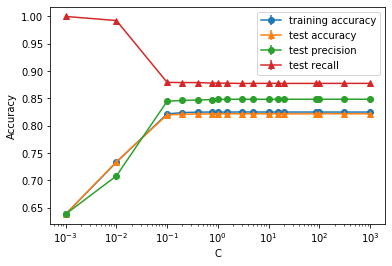

In [20]:
from sklearn.linear_model import LogisticRegression
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    classifier(LogisticRegression, X_scaled, y, iteration=10, penalty='l1', 
                   max_iter=10_000, solver='liblinear')

**INSIGHTS:** From the figure above, even though the best recall is when C=0.001, we choose C=0.1 to ensure that the test accuracy and precision will not be compromised greatly. Additionally, this is the value where the test scores become constant as the C increases. 

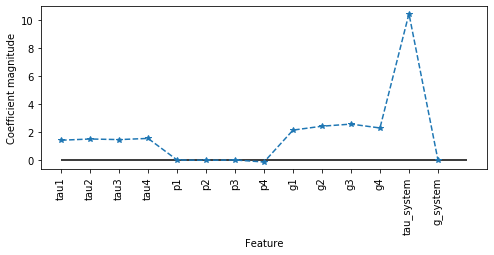

In [21]:
best_classifier = LogisticRegression(C=0.10, 
                                     penalty='l1', 
                                     solver='liblinear').fit(X_train, y_train)
weight_analysis(best_classifier, X)

**INSIGHTS:** From the figure, it can be seen that the top predictors are the `tau_system` parameter. This shows that the derived features are weighted more than the original features since it can more effectively divide the classifications from each other.

In [22]:
y_predict = best_classifier.predict(X_train)
index = np.where((y_predict == 'unstable'))[0]
confusion_matrix = get_confusion("unstable", index, y_train)
print("Train Precision is {:.6f}".format(precision(confusion_matrix)))
print("Train Recall is {:.6f}".format(recall(confusion_matrix)))
print("=========================")
y_predict = best_classifier.predict(X_test)
index = np.where((y_predict == 'unstable'))[0]
confusion_matrix = get_confusion("unstable", index, y_test)
print("Test Precision is {:.6f}".format(precision(confusion_matrix)))
print("Test Recall is {:.6f}".format(recall(confusion_matrix)))

Train Precision is 0.849367
Train Recall is 0.883804
Test Precision is 0.844923
Test Recall is 0.860815


### 7.4. Linear SVM with L2 regularization

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:40<00:00, 22.06s/it]


Highest Test Recall = 0.988401
Highest Test Precision = 0.723741
Highest Training Accuracy = 0.751427
Highest Test Accuracy = 0.751840
Best C Parameter = 0.001000


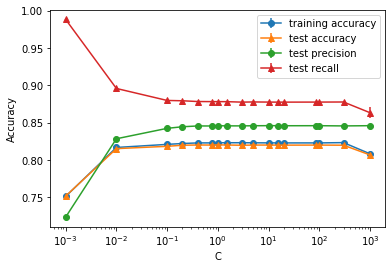

In [23]:
from sklearn.svm import LinearSVC
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    classifier(LinearSVC, X_scaled, y, iteration=10, penalty='l2', max_iter=10_000)

**INSIGHTS:** From the figure above, even though the best recall is when C=0.001, we choose C=0.1 to ensure that the test accuracy and precision will not be compromised greatly. Additionally, this is the value where the test scores become constant as the C increases. 

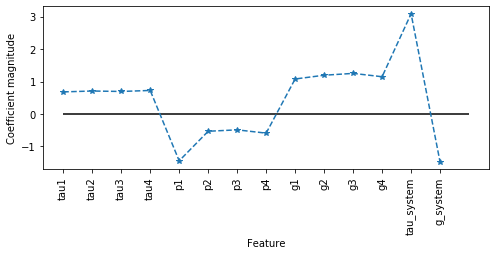

In [24]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    best_classifier = LinearSVC(C=0.1, penalty='l2').fit(X_train, y_train)
    weight_analysis(best_classifier, X)

**INSIGHTS:** From the figure, it can be seen that the top predictors are the `tau_system` parameter. This shows that the derived features are weighted more than the original features since it can more effectively divide the classifications from each other. Other parameters also have weights, but at a lower magnitude which shows that it is not as predictive as the `tau_system`.

In [25]:
y_predict = best_classifier.predict(X_train)
index = np.where((y_predict == 'unstable'))[0]
confusion_matrix = get_confusion("unstable", index, y_train)
print("Train Precision is {:.6f}".format(precision(confusion_matrix)))
print("Train Recall is {:.6f}".format(recall(confusion_matrix)))
print("=========================")
y_predict = best_classifier.predict(X_test)
index = np.where((y_predict == 'unstable'))[0]
confusion_matrix = get_confusion("unstable", index, y_test)
print("Test Precision is {:.6f}".format(precision(confusion_matrix)))
print("Test Recall is {:.6f}".format(recall(confusion_matrix)))

Train Precision is 0.846292
Train Recall is 0.884848
Test Precision is 0.843173
Test Recall is 0.859561


### 7.5. Linear SVM with L1 regularization

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:56<00:00, 29.69s/it]


Highest Test Recall = 1.000000
Highest Test Precision = 0.638000
Highest Training Accuracy = 0.638000
Highest Test Accuracy = 0.638000
Best C Parameter = 0.001000


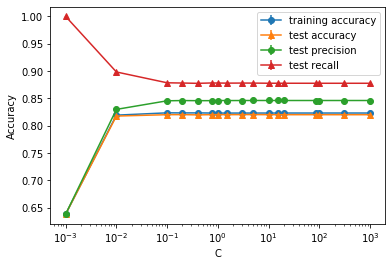

In [26]:
from sklearn.svm import LinearSVC
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    classifier(LinearSVC, X_scaled, y, iteration=10, penalty="l1", 
                   loss='squared_hinge', dual=False, max_iter=10_000)

**INSIGHTS:** From the figure above, even though the best recall is when C=0.001, we choose C=0.1 to ensure that the test accuracy and precision will not be compromised greatly. Additionally, this is the value where the test scores become constant as the C increases. 

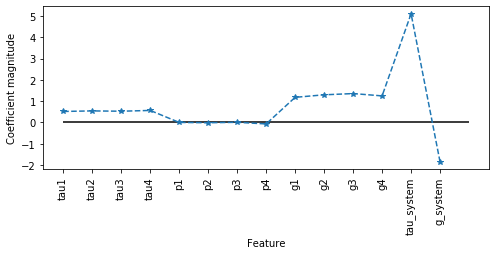

In [27]:
best_classifier = LinearSVC(C=0.1, penalty="l1", 
                                     loss='squared_hinge', 
                                     dual=False, 
                                     max_iter=10_000).fit(X_train, y_train)
weight_analysis(best_classifier, X)

**INSIGHTS:** From the figure, it can be seen that the top predictors are the `tau_system` parameter. This shows that the derived features are weighted more than the original features since it can more effectively divide the classifications from each other.

In [28]:
y_predict = best_classifier.predict(X_train)
index = np.where((y_predict == 'unstable'))[0]
confusion_matrix = get_confusion("unstable", index, y_train)
print("Train Precision is {:.6f}".format(precision(confusion_matrix)))
print("Train Recall is {:.6f}".format(recall(confusion_matrix)))
print("=========================")
y_predict = best_classifier.predict(X_test)
index = np.where((y_predict == 'unstable'))[0]
confusion_matrix = get_confusion("unstable", index, y_test)
print("Test Precision is {:.6f}".format(precision(confusion_matrix)))
print("Test Recall is {:.6f}".format(recall(confusion_matrix)))

Train Precision is 0.851351
Train Recall is 0.882132
Test Precision is 0.845393
Test Recall is 0.857053


### 7.6. Non-linear Support Vector

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
from sklearn.svm import SVC

recall_scorer = make_scorer(recall_score)
param_grids = {'C': [1, 2.5, 5, 10],
              'gamma': [1, 2.5, 5, 10],
               'degree': [3, 4, 5],
               'kernel': ['poly']
              }

svc_gs = SVC()
svc_cv = (GridSearchCV(svc_gs, param_grids, n_jobs=-1, scoring=recall_scorer)
          .fit(X_train, y_train.apply(lambda x: 1 if x=='unstable' else 0)))
print("Hyperparameters: ",svc_cv.best_params_)

print("Training Recall: ", svc_cv.score(X_train, 
                         y_train.apply(lambda x: 1 if x=='unstable' else 0)))
print("Testing Recall: ", svc_cv.score(X_test, 
                         y_test.apply(lambda x: 1 if x=='unstable' else 0)))

Hyperparameters:  {'C': 5, 'degree': 3, 'gamma': 1, 'kernel': 'poly'}
Training Recall:  0.9880877742946709
Testing Recall:  0.9705329153605016


**INSIGHTS:** Using GridSearchCV, we have determined that the hyperparameters with the best recall score is when C=5, gamma=1, degree=3 and kernel=poly. *Note that a wide range hyperparameters have been used in the GridSearchCV, only the parameters that yielded good results are placed on param_grids for computational speed*.

In [30]:
from sklearn.svm import SVC
best_classifier = (SVC(C=5, degree= 3, gamma= 1, kernel= 'poly')
                        .fit(X_train, y_train))

In [31]:
y_predict = best_classifier.predict(X_train)
index = np.where((y_predict == 'unstable'))[0]
confusion_matrix = get_confusion("unstable", index, y_train)
print("Train Precision is {:.6f}".format(precision(confusion_matrix)))
print("Train Recall is {:.6f}".format(recall(confusion_matrix)))
print("=========================")
y_predict = best_classifier.predict(X_test)
index = np.where((y_predict == 'unstable'))[0]
confusion_matrix = get_confusion("unstable", index, y_test)
print("Test Precision is {:.6f}".format(precision(confusion_matrix)))
print("Test Recall is {:.6f}".format(recall(confusion_matrix)))

Train Precision is 0.992027
Train Recall is 0.988088
Test Precision is 0.979747
Test Recall is 0.970533


### 7.7. Decision Tree

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.57s/it]

Highest Test Recall = 0.892038
Highest Test Precision = 0.847068
Highest Training Accuracy = 0.847613
Highest Test Accuracy = 0.828200
Best Depth Parameter = 5.000000


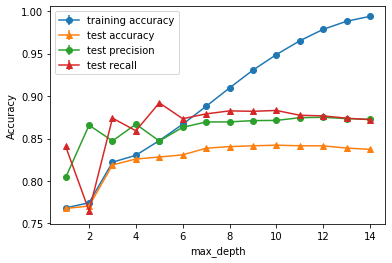

In [32]:
tree_classifier(X_scaled, y, iteration=10, depths=15)

**INSIGHTS:** From the figure, the best recall value is when max_depth=5. Because of this, we choose this value for max_depth. Additionally, this value does not greatly compromise the accuracy and precision of the prediction.

In [33]:
from sklearn.tree import DecisionTreeClassifier
best_classifier = DecisionTreeClassifier(criterion='gini', 
                        max_depth=5, random_state=10).fit(X_train, y_train)

In [34]:
y_predict = best_classifier.predict(X_train)
index = np.where((y_predict == 'unstable'))[0]
confusion_matrix = get_confusion("unstable", index, y_train)
print("Train Precision is {:.6f}".format(precision(confusion_matrix)))
print("Train Recall is {:.6f}".format(recall(confusion_matrix)))
print("=========================")
y_predict = best_classifier.predict(X_test)
index = np.where((y_predict == 'unstable'))[0]
confusion_matrix = get_confusion("unstable", index, y_test)
print("Test Precision is {:.6f}".format(precision(confusion_matrix)))
print("Test Recall is {:.6f}".format(recall(confusion_matrix)))

Train Precision is 0.881828
Train Recall is 0.887356
Test Precision is 0.865729
Test Recall is 0.848903


### 7.8. Random Forest

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer

recall_scorer = make_scorer(recall_score)
param_grids = {'max_depth': [3, 4, 5],
              'max_features': [3, 4, 5],
              'n_estimators': [100, 300, 500],
               'n_jobs': [-1]}

rf_gs = RandomForestClassifier()
rf_cv = (GridSearchCV(rf_gs, param_grids, n_jobs=-1, scoring=recall_scorer)
            .fit(X_train, y_train.apply(lambda x: 1 if x=='unstable' else 0)))
print("Hyperparameters: ", rf_cv.best_params_)
print("Training Recall: ", rf_cv.score(X_train, 
                        y_train.apply(lambda x: 1 if x=='unstable' else 0)))
print("Testing Recall: ", rf_cv.score(X_test, 
                        y_test.apply(lambda x: 1 if x=='unstable' else 0)))

Hyperparameters:  {'max_depth': 3, 'max_features': 3, 'n_estimators': 300, 'n_jobs': -1}
Training Recall:  0.942110762800418
Testing Recall:  0.9266457680250784


**INSIGHTS:** Using GridSearchCV, we have determined that the hyperparameters with the best recall score is when max_depth=3, max_features=3, and n_estimators=500. *Note that a wide range hyperparameters have been used in the GridSearchCV, only the parameters that yielded good results are placed on param_grids for computational speed*.

In [36]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(max_depth= 3, max_features= 3, 
                  n_estimators=500).fit(X_train, y_train)

In [37]:
y_predict = forest.predict(X_train)
index = np.where((y_predict == 'unstable'))[0]
confusion_matrix = get_confusion("unstable", index, y_train)
print("Train Precision is {:.6f}".format(precision(confusion_matrix)))
print("Train Recall is {:.6f}".format(recall(confusion_matrix)))
print("=========================")
y_predict = forest.predict(X_test)
index = np.where((y_predict == 'unstable'))[0]
confusion_matrix = get_confusion("unstable", index, y_test)
print("Test Precision is {:.6f}".format(precision(confusion_matrix)))
print("Test Recall is {:.6f}".format(recall(confusion_matrix)))

Train Precision is 0.822089
Train Recall is 0.947335
Test Precision is 0.820428
Test Recall is 0.936677


### 7.9. Gradient Boosting

In [38]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer

recall_scorer = make_scorer(recall_score)
param_grids = {'learning_rate': [0.30, 0.20, 0.10],
              'max_depth': [2, 3, 4],
              'max_features': [None, 5],
              'n_estimators': [100, 300,500]
               }   

gbm_gs = GradientBoostingClassifier()
gs_cv = (GridSearchCV(gbm_gs, param_grids, n_jobs=-1, scoring=recall_scorer)
         .fit(X_train, y_train.apply(lambda x: 1 if x=='stable' else 0)))
print("Hyperparameters: ", gs_cv.best_params_)

print("Training Recall: ", gs_cv.score(X_train, 
                            y_train.apply(lambda x: 1 if x=='stable' else 0)))
print("Testing Recall: ", gs_cv.score(X_test, 
                            y_test.apply(lambda x: 1 if x=='stable' else 0)))

Hyperparameters:  {'learning_rate': 0.3, 'max_depth': 3, 'max_features': None, 'n_estimators': 500}
Training Recall:  1.0
Testing Recall:  0.9259668508287293


**INSIGHTS:** Using GridSearchCV, we have determined that the hyperparameters with the best recall score is when learning_rate=0.3, max_depth=3, max_features=None, and n_estimators=500. *Note that a wide range hyperparameters have been used in the GridSearchCV, only the parameters that yielded good results are placed on param_grids for computational speed*.

In [39]:
from sklearn.ensemble import GradientBoostingClassifier
gbm = (GradientBoostingClassifier(learning_rate=0.3, max_depth= 3, 
                max_features= None, n_estimators= 500).fit(X_train, y_train))

In [40]:
y_predict = gbm.predict(X_train)
index = np.where((y_predict == 'unstable'))[0]
confusion_matrix = get_confusion("unstable", index, y_train)
print("Train Precision is {:.6f}".format(precision(confusion_matrix)))
print("Train Recall is {:.6f}".format(recall(confusion_matrix)))
print("=========================")
y_predict = gbm.predict(X_test)
index = np.where((y_predict == 'unstable'))[0]
confusion_matrix = get_confusion("unstable", index, y_test)
print("Test Precision is {:.6f}".format(precision(confusion_matrix)))
print("Test Recall is {:.6f}".format(recall(confusion_matrix)))

Train Precision is 1.000000
Train Recall is 1.000000
Test Precision is 0.957702
Test Recall is 0.951097


### 7.10. Summary of Classifiers

The summary of all results are as follows:

| Classifier | Recall | Precision| 
|--|--|--|
|kNN Classifier |0.945455 | 0.865175|
| Logistic Regression (L2)| 0.935423 | 0.797009 | 
| Logistic Regression (L1) | 0.860815 | 0.844403 |
| Linear SVM (L2) | 0.859561 | 0.843173 |
| Linear SVM  (L1) | 0.857053 | 0.845393 |
| **Non-Linear SVM** | **0.970533** | **0.979747** |
| Decision Trees | 0.848903 | 0.865729 |
| Random Forest | 0.931661 | 0.819184|
| Gradient Boosting | 0.950470 | 0.957675 |


From the results of the machine learning models, we can conclude that the **Non-Linear Support Vector** Machine yielded the best recall score and is the most applicable machine learning model for this specific problem. Besides the high recall score that was achieved, a high precision score was also achieved. The **balance between the precision and recall scores** shows the appropriateness of this model to the problem at hand. 

The high and balanced precision and recall scores can be attributed to the use of domain knowledge in the problem at hand. Since my domain knowledge tells me that the relationship between P, tau and gamma is a polynomial combination of these parameters, the kernel used for the Non-Linear Support Vector Machine was a polynomial kernel. This configuration greatly improved the model to achieve a high precision and recall score.


## 8. Top Features

We used the Random Forests, and Gradient Boosting method (as shown below) to determine which are the top features that can classify a stable and unstable power system operation. Based on the feature_imporances_ method of these three classfiers, we have determined that the top features that can classify the system operation is the `tau_system`, `g_system`, `tau` and `g` parameters. 

Surprisingly, the `P` of the power consumed does not have a feature importance in a power system with decentralized control. This means that how the Advanced Metering Infrastuctures (AMI) or Smart Meters are set and configured plays a big role in the successful operation of a network with decentralized control. 

#### Random Forests

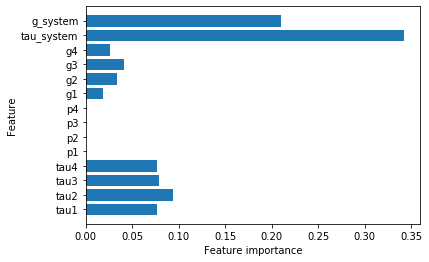

In [41]:
plot_feature_importances(forest, grid.drop(['stabf', 'stab'], axis=1))

#### Gradient Boosting

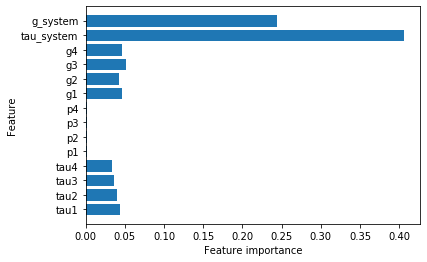

In [42]:
plot_feature_importances(gbm, grid.drop(['stabf', 'stab'], axis=1))

## 9. Determining the Tipping Point

The top feature that determines whether the system will fall into a stable or unstable operation is based primarily on the `tau_system` as shown in the Random Forests and Gradient Boosting Trees. Building up from this idea, we can determine the point where the system will fall into the unstable operation by incrementing the values of the `tau_system` and predicting the system outcome using the training dataset. 

The following flowchart of methodology will be used:

<img src="src/flowchart.png" width = "300"/> 

In [43]:
from sklearn.svm import SVC
best_classifier = (SVC(C=5, degree= 3, gamma= 1, kernel= 'poly')
                        .fit(X_train, y_train))
y_predict = best_classifier.predict(X_test)

In [44]:
index_stable = np.where((y_predict == 'stable'))[0]
stables = X_test[index_stable]

In [45]:
results = []
total_increment = []

for no in tqdm(range(stables.shape[0])):
    row_data = stables[no, :].copy()
    additional = 0
    
    for increment in np.arange(0, 1, 0.001):
        sample_data = row_data.copy()
        sample_data[:4] = sample_data[:4] + increment
        sample_data[12:13] = sample_data[12:13] + increment**4
        predict = best_classifier.predict([sample_data])
        
        if predict == 'stable': 
            additional+=0.001
        if predict == 'unstable': 
            results.append(sample_data)
            total_increment.append(additional)
            break
    continue

100%|████████████████████████████████████████████████████████████████████████████████| 920/920 [00:17<00:00, 51.91it/s]


In [46]:
np.mean(total_increment)

0.1588418756815704

**INSIGHTS:** By incrementing the operating parameters, we have determined that a 15% increment in the `tau_system` will be enough to flip a stable grid operation into an unstable grid operation. This information will be useful in grid planning and development to ensure that the infrastructures developed will be optimized to minimize the occurence of unstable grid operations. 

## 10. Summary of Takeaways

1. The use of appropriate kernels will very much improve the accuracy of a Non-Linear Support Vector Machine model. In choosing the right kernel to be used, domain knowledge plays a big role since it will provide the underlying reason whether the common kernels should be used or if a custom kernel should be developed. 

2. The trained models can be used to predict the values at which the classification of the data will change/ flip. This can be done by incrementing the values of the original dataset repeatedly and predicting if the new value will be the same or not. When the classification of the data has flipped, the value of the increments can be considered the threshold or the borderline of the two state conditions. This information will be valuable to industry practitioners to be able to pinpoint the dividing characteristics between the classifications. 

### References
1. Electrical Grid Stability Simulated Data Data Set; [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Electrical+Grid+Stability+Simulated+Data+)

2. Towards Concise Models of Grid Stability;  [Arzamasov,  Böhm,  Jochem](https://dbis.ipd.kit.edu/download/DSGC_simulations.pdf)

3. Taming instabilities in power grid networks by decentralized control; [Sch¨afer,  Grabow, Auer, etal](https://cfaed.tu-dresden.de/files/user/mtimme/publications/Schaefer_et_al_Taming%20instabilities%20in%20power%20grid%20networks%20by%20decentrealized%20control_EPJST_2016.pdf)


In [47]:
# Add cells above this
# This will generate the html report for this notebook
!jupyter nbconvert  "Power Up or Power Out.ipynb" --to html


[NbConvertApp] Converting notebook Power Up or Power Out.ipynb to html
[NbConvertApp] Writing 4896696 bytes to Power Up or Power Out.html
